In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import DataSplitter

In [3]:
df60 = DataSplitter.getTrainData(60)

# Input diff, output diff
#target_column = "diff"
#drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]

# Input diff, output passengers
target_column = "passengersBoarding"
#target_column_diff = "diff"
#drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "diff", "datetime", "eventName"]
drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "datetime", "eventName"]

train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"]
val60_1A = val60[val60["line"] == "1A"]

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)
#y_train_diff = train60_1A[target_column].reset_index(drop=True)
#y_val_diff = val60_1A[target_column_diff].reset_index(drop=True)

In [4]:
batchSize = 32  # len(X_train)//20

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)

valDataset = TensorDataset(X_val_tensor, y_val_tensor)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

In [5]:
def evaluation(model, loader, criterion, device):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_idx, (Xbatch, ybatch) in enumerate(loader):
            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)
                
            predictions = model(Xbatch.unsqueeze(-1)).squeeze()

            loss = criterion(predictions, ybatch)
            total_loss.append(loss.item())
    return np.mean(total_loss)

In [6]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=4, output_size=1, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


In [7]:
def train_LSTM(model, trainLoader, valLoader=[], totalEpochs=100, lr=1e-3, device="cpu", save_loss=False):
    device = torch.device(device)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction="mean")

    train_loss_list = []
    val_loss_list = []
    nEpochs = range(1, totalEpochs + 1)
    for epoch in nEpochs:
        model.train()
        total_loss = []
        for batch_idx, (Xbatch, ybatch) in enumerate(trainLoader):
            optimizer.zero_grad()

            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)

            predictions = model(Xbatch.unsqueeze(-1)).squeeze()

            loss = criterion(predictions, ybatch)
                
            loss.backward()

            optimizer.step()

            total_loss.append(loss.item())

        if len(valLoader) != 0:
            total_loss_mean = np.mean(total_loss)
            train_loss_list.append(total_loss_mean)

            val_loss_mean = evaluation(model, valLoader, criterion, device)
            val_loss_list.append(val_loss_mean)

            if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Train Loss: {total_loss_mean}, Val Loss: {val_loss_mean}")

    train_loss_list = np.array(train_loss_list)
    val_loss_list = np.array(val_loss_list)

    if save_loss:
        np.save(train_loss_list, "train_loss.npy")
        np.save(val_loss_list, "val_loss.npy")
    model = model.to("cpu")

    return (model, nEpochs, train_loss_list, val_loss_list)

model, nEpochs, train_loss_list, val_loss_list = train_LSTM(LSTM(), trainLoader, valLoader, totalEpochs=20, lr=1e-3, device="cuda")

Epoch: 10, Train Loss: 0.10148340096790547, Val Loss: 0.09275328297296474
Epoch: 20, Train Loss: 0.0730897492621589, Val Loss: 0.07975640507607624


In [79]:
from IPython.display import clear_output

def removeGTLags(col, lagColName):
    lag = int(col.name[len(lagColName):])
    col.loc[lag:] = np.nan

def updateLagsWithRealValues(col, lagColName, realValues, horizon):
    if lagColName in col.name:
        latest_realValues = realValues[-horizon:]
        lag = int(col.name[len(lagColName):])

        start_val = np.max([0, lag - horizon])
        end_val = np.min([lag, horizon])
        for i in range(end_val):
            col.iloc[(start_val+i):(start_val+i+1)] = latest_realValues[-(end_val-i)]

def fixedWindowForecastPytorch(X_train, y_train, X_val, y_val, y_train_diff, y_val_diff, lagColName, model, batchSize, epochs, lr, device, horizon):
    scaler_X = StandardScaler()  # Initialize a scaler_X
    X_train_no_lag = X_train.loc[:, ~X_train.columns.str.startswith(lagColName)]  # Find the columns in X_train, which are not lags
    X_val_no_lag = X_val.loc[:, ~X_val.columns.str.startswith(lagColName)]        # Find the columns in X_val, which are not lags
    X_train_no_lag_scaled = scaler_X.fit_transform(X_train_no_lag)                # scaler_X is fitted to the columns of X_tran, which are not lags
    X_val_no_lag_scaled = scaler_X.transform(X_val_no_lag)                        # scaler_X is used to transform the columns of X_val, which are not lags
    X_train_no_lag_scaled_df = pd.DataFrame(X_train_no_lag_scaled, columns=X_train_no_lag.columns)  # The scaled values are then type np.array. We also save as dataframe
    X_val_no_lag_scaled_df = pd.DataFrame(X_val_no_lag_scaled, columns=X_val_no_lag.columns)        # for both train and val

    scaler_y = StandardScaler()  # Initialize a scaler_y
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # scaler_y is fittet to y_train
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))          # scaler_y is used to transform y_val

    scaler_diff = StandardScaler()  # Initialize a scaler_diff
    X_train_lag = X_train.loc[:, X_train.columns.str.startswith(lagColName)]                                  # Find the columns in X_train, which are lags
    X_val_lag = X_val.loc[:, X_val.columns.str.startswith(lagColName)]                                        # Find the columns in X_val, which are lags
    y_train_diff_scaled = pd.Series(scaler_diff.fit_transform(y_train_diff.values.reshape(-1, 1)).squeeze())  # scaler_diff is fitted to y_train_diff
    y_val_diff_scaled = pd.Series(scaler_diff.transform(y_val_diff.values.reshape(-1, 1)).squeeze())          # scaler_diff is used to transform y_val_diff
    # Loop over every column name
    for column in X_train_lag.columns:
        X_train_lag[column] = pd.Series(scaler_diff.transform(X_train_lag[column].values.reshape(-1, 1)).squeeze())  # scaler_diff is used to transform each lag column
        X_val_lag[column] = pd.Series(scaler_diff.transform(X_val_lag[column].values.reshape(-1, 1)).squeeze())      # for both train and val

    X_train_scaled = np.concatenate((X_train_no_lag_scaled, X_train_lag.values), axis=1)  # Concatenates the scaled exogenous X_train columns with the scaled X_train lagged columns
    X_val_scaled = np.concatenate((X_val_no_lag_scaled, X_val_lag.values), axis=1)        # Concatenates the scaled exogenous X_val columns with the scaled X_val lagged columns

    # Turn the scaled lists into tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

    # Turn the tensors into tensordatasets and dataloaders
    initial_trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
    initial_trainLoader = DataLoader(initial_trainDataset, batch_size=batchSize, shuffle=False)
    initial_valDataset = TensorDataset(X_val_tensor, y_val_tensor)
    initial_valLoader = DataLoader(initial_valDataset, batch_size=batchSize, shuffle=False)

    # Estimate LSTM model
    estimated_model, _, _, _ = train_LSTM(model, initial_trainLoader, initial_valLoader, totalEpochs=epochs, lr=lr, device=device)

    X_val_lag.apply(removeGTLags, args=(lagColName,))  # Calls the removeGTLags function on all columns, which removes the lags that would not yet be known from the starting point of the forecast
    X_val_gt_removed_scaled = pd.concat((X_val_no_lag_scaled_df, X_val_lag), axis=1)  # Concatenates the known scaled exogenous variables with the unknown lags that have been removed
    y_gt = y_val_diff_scaled.squeeze().tolist()  # Creates a ground truth list of observations, that will be replacing the forecasted lag values after each <horizon> step
    y_pred = []  # Initialize a prediction list for predictions
    y_pred.append(y_train_scaled[-1][0])  # Add the last target value to be used for first differencing the first prediction
    iterations = 0  # Keep track of iterations
    first_iter = True

    # While there is still values left in validation set to be forecasted
    while len(X_val_gt_removed_scaled) != 0:
        # Update iteration and print
        iterations += 1
        print(iterations)
        clear_output(wait=True)

        # Find how many steps to forecast (always length of horizon except for last iteration)
        steps = np.min([horizon, len(X_val)])
        for _ in range(0, steps):
            X_fit_tensor = torch.FloatTensor(X_val_gt_removed_scaled.iloc[0:1].values)  # Select the first row in the validation set and turn it into tensor
            y_pred.append(estimated_model(X_fit_tensor.unsqueeze(-1)).detach().squeeze().numpy().tolist())  # Use the estimated model to predict the next value from the first row tensor, and add it to predictions
                                                                        # pred is the predicted TRUE NUMBERS and not the DIFFERENCED!
            X_val_gt_removed_scaled = X_val_gt_removed_scaled.apply(lambda col: col.fillna(y_pred[-1] - y_pred[-2], limit=1))             # Add the next row in each lag column
            if first_iter:
                first_iter = False
                y_pred = y_pred[1:]  # Remove the first target value that was used for differencing the first prediction
            X_val_gt_removed_scaled = X_val_gt_removed_scaled.drop(X_val_gt_removed_scaled.index[0]).reset_index(drop=True)  # Drop the row that was just used and reset the index of the dataframe

        # After forecasting the steps is finished
        X_val_gt_removed_scaled.apply(updateLagsWithRealValues, lagColName=lagColName, realValues=y_gt, horizon=horizon)  # Calls the updateLagsWithRealValues function on all columns, which inserts the ground truth values in the lags instead of the predicted values
        y_gt = y_gt[horizon:]  # Remove the <horizon> ground truth values that have been inserted into the lags
    
    return pd.Series(scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)).squeeze())  # Inverse transform the predictions and output as type pd.Series

In [80]:
predictions = fixedWindowForecastPytorch(X_train, y_train, X_val, y_val, y_train_diff, y_val_diff, "diffLag", LSTM(), batchSize=32, epochs=100, lr=1e-3, device="cuda", horizon=40)

46


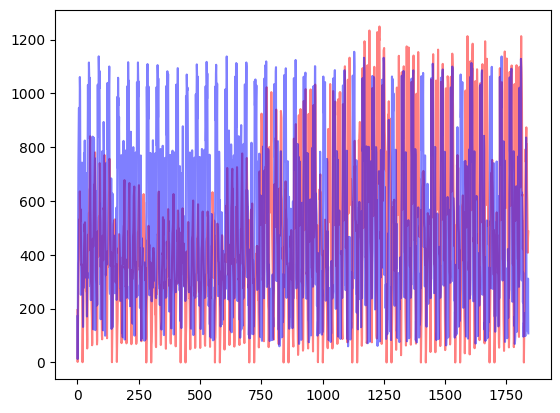

In [81]:
import matplotlib.pyplot as plt

plt.plot(y_val, color="red", alpha=0.5)
plt.plot(predictions, color="blue", alpha=0.5)

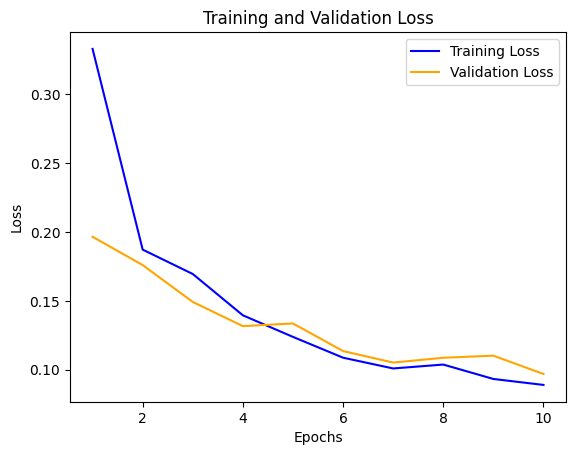

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nEpochs, train_loss_list, "blue", label="Training Loss")
plt.plot(nEpochs, val_loss_list, "orange", label="Validation Loss")

#plt.xlim(500, 1000)
#plt.ylim(0.05, 0.35)

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

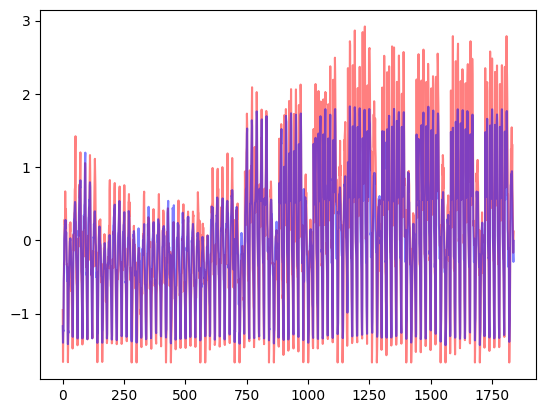

In [ ]:
y_val_pred_scaled = pd.Series(model(X_val_tensor.unsqueeze(-1)).squeeze().detach())
y_val_pred = pd.Series(scaler_y.inverse_transform(model(X_val_tensor.unsqueeze(-1)).detach()).squeeze())

plt.plot(y_val_scaled, color="red", alpha=0.5)
plt.plot(y_val_pred_scaled, color="blue", alpha=0.5)

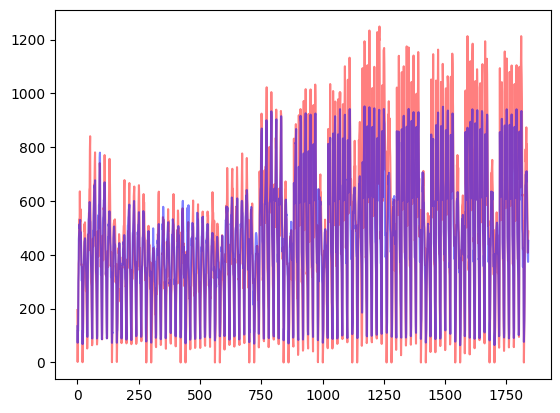

In [ ]:
plt.plot(y_val, color="red", alpha=0.5)
plt.plot(y_val_pred, color="blue", alpha=0.5)

In [ ]:
period = 40
val60_line_extended = pd.concat([train60_1A['passengersBoarding'].tail(period), val60_1A['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_1A['diff'].tail(period), y_val_pred], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

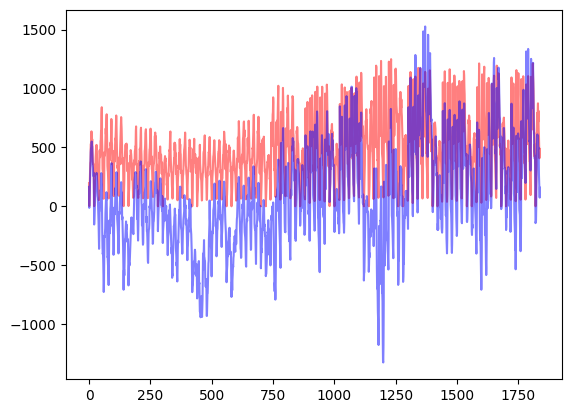

In [ ]:
plt.plot(val60_1A["passengersBoarding"].reset_index(drop=True), color="red", alpha=0.5)
plt.plot(y_val_pred_passengers.reset_index(drop=True), color="blue", alpha=0.5)

In [ ]:
from utils import MAE, MAPE, RMSE
print("MAE%:", MAE(y_val, y_val_pred))
print("MAPE:", MAPE(y_val, y_val_pred))
print("RMSE%:", RMSE(y_val, y_val_pred))

MAE%: 0.147
MAPE: 0.354
RMSE%: 0.202


## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM